# Plots and Numbers
production calculations and plots used in the paper.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from joblib import Parallel, delayed
from scipy.integrate import cumtrapz
from scipy import stats

from GWMockCat.vt_utils import interpolate_optimal_snr_grid
from GWMockCat.cosmo_utils import interp_cosmology
from bilby.core.result import read_in_result

from gw_lensing_outliers import transforms as trans
from gw_lensing_outliers import analysis_functions as af
from gw_lensing_outliers.dists import ZMAX
from gw_lensing_outliers import dists

matplotlib.rcParams["contour.negative_linestyle"]="solid"
matplotlib.rcParams["text.usetex"]=True
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['font.size']=12
plt.rcParams.update( {'axes.labelsize':12, 'axes.titlesize':12, 'legend.fontsize':10, 'text.usetex':True} )

color_og_light, color_og_dark = "#8da0cb", "#7570b3"
color_lensing_light, color_lensing_dark =  "#66c2a5", "#1b9e77"
color_alt_light, color_alt_dark = "#fc8d62", "#d95f02"

TEST_LNMU = np.linspace(np.log(0.4),np.log(200),num=150)
TEST_MU = np.exp(TEST_LNMU)
MU_MAX = 2500
TEST_TAU = np.linspace(0,1,num=200)
M1_TEST = np.linspace(1,100,num=100)
Q_TEST = np.linspace(0,1,num=25)
N_EVS = 69
GWMOCKCAT_COSMO_DICT = interp_cosmology(zmax=20)
O3_MEASUREMENT_UNCERTAINTY = dict(threshold_snr=8.,snr=1.,mc=0.08,Theta=0.21,eta=0.022) 

np_rng = np.random.default_rng(63)

## Universal calculations needed for several plots

In [5]:
# set detector sensitivity. take file from GWMockCat release
detector = "aligo_O3actual_L1"
osnr, dist_unit = interpolate_optimal_snr_grid(
            f"/Users/amandafarah/Library/Mobile Documents/com~apple~CloudDocs/projects/mock-PE/sensitivity/optimal_snr_{detector}.h5")

# load population data
samples = read_in_result(
    "/Users/amandafarah/Downloads/mixture_ogpriors_except_mmax130_gmax100_result.json"
    ).posterior

# draw injections
Ninj = int(1e8)
draw_distribution_params = samples.mean()
draw_distribution_params['delta_m'] = 4.95

INJECTIONS = af.make_injections(np_rng,
                                Ninj,
                                draw_distribution_params,
                                z_bounds=[0.001,dists.ZMAX],
                                mass_bounds=[1,130],
                                mu_bounds=[0.3,dists.MU_MAX],
)
m1max = draw_distribution_params['mmax']

# calculate OUTLIER_THRESH-th quantile for distance and m1 based on these samples
m1max_thresh, Dmin_thresh = af.create_ppds(np_rng,
                                           samples,
                                           optimal_snr_interpolator=osnr,
                                           distance_unit=dist_unit,
                                           uncert_dict=O3_MEASUREMENT_UNCERTAINTY,
                                           cosmo_dict=GWMOCKCAT_COSMO_DICT)
zmin_thresh = trans.z_at_dl_approx(Dmin_thresh)

# load the grid on which we pre-calculated p(mu|z,t0c) and turn it into a function we can evaluate for reweighting 
mu_interp, ln_mu_space, z_space, t_const_space = af.make_Dai_interpolant('../data/Dai_logmag_pdf_recalibrated_t0const_neg0p36_100_grid.h5',make_new=False, return_grids=True)

# calculate the optical depth, tau, of magnifications greater than muprime at z=reference_redshift, as a function of t0c
muprime = 5
reference_redshift = 1
TAU_ARR = np.zeros_like(t_const_space)
for i in range(t_const_space.size):
    TAU_ARR[i] = af.tau_from_t0c(5,1,t_const_space[i],mu_interp)
TAU_FID = af.tau_from_t0c(muprime,reference_redshift,0.00,mu_interp)
with open("../output/fiducial_tgf.tex", 'w') as f:
    str_list = f"{TAU_FID:.2E}".split("E")
    str_list[-1] = "{"+str_list[-1][0] + str_list[-1][-1] +"}"
    expr = "\\times 10^".join(str_list)
    print(f"${expr}$",file=f)


# Figure 1
Scatter plot demonstrating draws from the population, colored by their magnification.
One panel can be the true params, other can be the inferred ones. Show the effect of magnification and that some of the high-mu ones are outliers, and they are helped by being close to the edges already.

In [6]:
t0c=5
# downsample a lot for ease of plotting
target_num = int(5e3)
    
select = True
if select:
    # select them
    obs_found_evs, identified_evs = af.find_injections(np_rng,INJECTIONS,m1max_thresh,Dmin_thresh,osnr,dist_unit,O3_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)
else:
    obs_found_evs = INJECTIONS
    
# reweight injections to a heavy-tailed magnification distribution
weights = mu_interp((np.log(obs_found_evs['magnification']),obs_found_evs['true_redshift'],t0c))/obs_found_evs['lnmu_pdraw']
weights /= np.sum(weights)
rw_idx = np_rng.choice(len(obs_found_evs['magnification']),size=target_num,p=weights,replace=True)
rw_injections = {key:obs_found_evs[key][rw_idx] for key in obs_found_evs.keys() if 'num' not in key}

rw_mags = rw_injections['magnification']
inferred_redshifts = rw_injections['inferred_redshift']
inferred_distances = rw_injections['inferred_distance']
true_distances = inferred_distances * np.sqrt(rw_mags)
true_redshifts = trans.z_at_dl_approx(true_distances) # have to do it this way bc 'true_redshift' entry in injection dict doesn't have meas. uncert.
det_masses = rw_injections['det_mass']

18371605 found injections
361122 injections found and identified as outliers


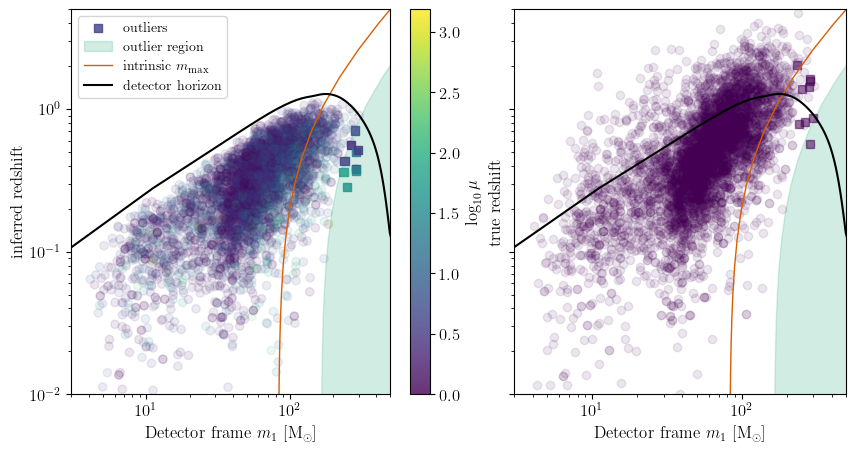

number of outliers: 9


In [8]:
# plot the  events
f, ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True,gridspec_kw={'wspace':0.12,'width_ratios':[1.2,1]})

squares = det_masses/(1+inferred_redshifts) > m1max_thresh

vmax = np.log10(rw_mags).max()
s = ax[0].scatter(det_masses,inferred_redshifts,c=np.log10(rw_mags),alpha=0.10,cmap='viridis', vmin=0,vmax=vmax)
s = ax[0].scatter(det_masses[squares],inferred_redshifts[squares],marker='s',c=np.log10(rw_mags[squares]),alpha=0.8,cmap='viridis', vmin=0,vmax=vmax,
                  label='outliers')

ax[1].scatter(det_masses,true_redshifts,color=plt.colormaps['viridis'].get_under(),alpha=0.1)
ax[1].scatter(det_masses[squares],true_redshifts[squares],marker="s",color=plt.colormaps['viridis'].get_under(),alpha=0.5)
f.colorbar(s,label='$\log_{10}\mu$')

m1_dummy = np.linspace(1,1000,num=100)
z_dummy = np.logspace(np.log(zmin_thresh),np.log(ZMAX))
horizon = osnr(m1_dummy,m1_dummy,grid=False)/8
for i in range(2):
    # redshift lower limit
    ax[i].fill_between(m1_dummy, zmin_thresh*np.ones_like(m1_dummy),color=color_lensing_light,alpha=0.3,ec=None)
    # source frame mass upper limit
    ax[i].fill_betweenx(x1=m1max_thresh*(1+z_dummy),x2=1000,y=z_dummy,color=color_lensing_light,alpha=0.3,zorder=0,
                        label='outlier region') #ec=None,
    # mmax for source frame true masses
    ax[i].plot(m1max*(1+z_dummy),z_dummy,color=color_alt_dark,lw=1,label="intrinsic $m_{\max}$")
    # detector horizon
    ax[i].plot(m1_dummy,trans.z_at_dl_approx(horizon),c='k',label='detector horizon')
    ax[i].set_xlabel('Detector frame $m_1$ [M$_\odot$]')

plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2, 5)
plt.xlim(3,500)
ax[0].legend(loc='upper left')
ax[1].set_ylabel('true redshift')
ax[0].set_ylabel('inferred redshift')
plt.savefig("../plots/fig1.pdf")
plt.show()

with open("../output/num_outliers_fig1.txt", 'w') as f:
    print(f"{squares.sum()}",file=f)
    print(f"number of outliers: {squares.sum()}")

# Figure 3
Same as Figure 1, but with different $t_0^c$. Could maybe just combine this into one figure with fig 1?

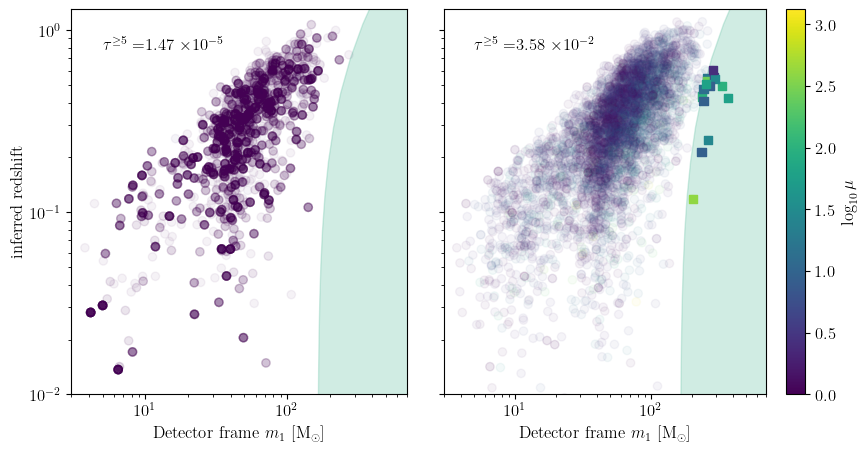

In [9]:
# reweigh
t0c=19
tau = af.tau_from_t0c(5,1,t0c,mu_interp)
weights = mu_interp((np.log(obs_found_evs['magnification']),obs_found_evs['true_redshift'],t0c))/obs_found_evs['lnmu_pdraw']
weights /= np.sum(weights)
rw_idx = np_rng.choice(len(obs_found_evs['magnification']),size=target_num,p=weights,replace=True)
rw_injections = {key:obs_found_evs[key][rw_idx] for key in obs_found_evs.keys() if 'num' not in key}
mags = rw_injections['magnification']
inferred_redshifts = rw_injections['inferred_redshift']
inferred_distances = rw_injections['inferred_distance']
true_distances = inferred_distances * np.sqrt(mags)
true_redshifts = trans.z_at_dl_approx(true_distances) 
det_masses = rw_injections['det_mass']

# plot
f, ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=True,gridspec_kw={'wspace':0.1,'width_ratios':[1,1.2]})
max_mag = np.log10(mags).max()
squares = det_masses/(1+inferred_redshifts) > m1max_thresh
ax[1].scatter(det_masses,inferred_redshifts,c=np.log10(mags),alpha=0.05,cmap='viridis', vmin=0,vmax=max_mag)
s = ax[1].scatter(det_masses[squares],inferred_redshifts[squares],c=np.log10(mags[squares]),marker='s',alpha=1,cmap='viridis', vmin=0,vmax=max_mag)

formatted_tau = f'{tau:.2e}'.split('e')
formatted_tau = f"{formatted_tau[0]} $\\times 10^{{{formatted_tau[1][0]+formatted_tau[1][2]}}}$"
ax[1].annotate('$\\tau^{\geq 5}=$'+f'{formatted_tau}',xy=(5,.8))
f.colorbar(s,label='$\log_{10}\mu$')


# again
t0c=0.0
tau = af.tau_from_t0c(5,1,t0c,mu_interp)
weights = mu_interp((np.log(obs_found_evs['magnification']),obs_found_evs['true_redshift'],t0c))/obs_found_evs['lnmu_pdraw']
weights /= np.sum(weights)
rw_idx = np_rng.choice(len(obs_found_evs['magnification']),size=target_num,p=weights,replace=True)
rw_injections = {key:obs_found_evs[key][rw_idx] for key in obs_found_evs.keys() if 'num' not in key}
mags = rw_injections['magnification']
inferred_redshifts = rw_injections['inferred_redshift']
inferred_distances = rw_injections['inferred_distance']
true_distances = inferred_distances * np.sqrt(mags)
true_redshifts = trans.z_at_dl_approx(true_distances)
det_masses = rw_injections['det_mass']

squares = det_masses/(1+inferred_redshifts) > m1max_thresh
ax[0].scatter(det_masses,inferred_redshifts,c=np.log10(mags),alpha=0.05,cmap='viridis', vmin=0,vmax=max_mag)
ax[0].scatter(det_masses[squares],inferred_redshifts[squares],c=np.log10(mags[squares]),marker='s',alpha=1,cmap='viridis', vmin=0,vmax=max_mag)
formatted_tau = f'{tau:.2e}'.split('e')
formatted_tau = f"{formatted_tau[0]} $\\times 10^{{{formatted_tau[1][0]+formatted_tau[1][2]}}}$"
ax[0].annotate('$\\tau^{\geq 5}=$'+f'{formatted_tau}',xy=(5,.8))

# formatting
for i in range(2):
    ax[i].fill_between(m1_dummy, zmin_thresh*np.ones_like(m1_dummy),color=color_lensing_light,alpha=0.3,ec=None)
    ax[i].fill_betweenx(x1=m1max_thresh*(1+z_dummy),x2=1000,y=z_dummy,color=color_lensing_light,alpha=0.3,zorder=0)
    ax[i].set_xlabel('Detector frame $m_1$ [M$_\odot$]')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-2,1.3)
plt.xlim(3,700)
ax[0].set_ylabel('inferred redshift')
plt.savefig("../plots/detected_dist_diff_taus.pdf")
plt.show()
# besides not enough original samples at low magnification, this looks great!

# Figure 2
Mangification distribution and tau

/Users/amandafarah/Library/Mobile Documents/com~apple~CloudDocs/projects/GW-lensing-outliers-public/gw_lensing_outliers/gw_lensing_outliers/dists.py:177: RuntimeWarning: overflow encountered in exp
  A = 1./np.trapz(y=np.exp(lam/(tgrid+t0grid)-2*tgrid),x=tgrid,axis=1)
/Users/amandafarah/Library/Mobile Documents/com~apple~CloudDocs/projects/GW-lensing-outliers-public/gw_lensing_outliers/gw_lensing_outliers/dists.py:178: RuntimeWarning: overflow encountered in exp
  p = np.trapz(y=np.exp(lam/(tgrid+t0grid)-2*tgrid)*np.exp(-(logmugrid - deltagrid - tgrid)**2/(2*sigmagrid**2)),
/Users/amandafarah/Library/Mobile Documents/com~apple~CloudDocs/projects/GW-lensing-outliers-public/gw_lensing_outliers/gw_lensing_outliers/dists.py:178: RuntimeWarning: invalid value encountered in multiply
  p = np.trapz(y=np.exp(lam/(tgrid+t0grid)-2*tgrid)*np.exp(-(logmugrid - deltagrid - tgrid)**2/(2*sigmagrid**2)),
/Users/amandafarah/Library/Mobile Documents/com~apple~CloudDocs/projects/GW-lensing-outliers-publ

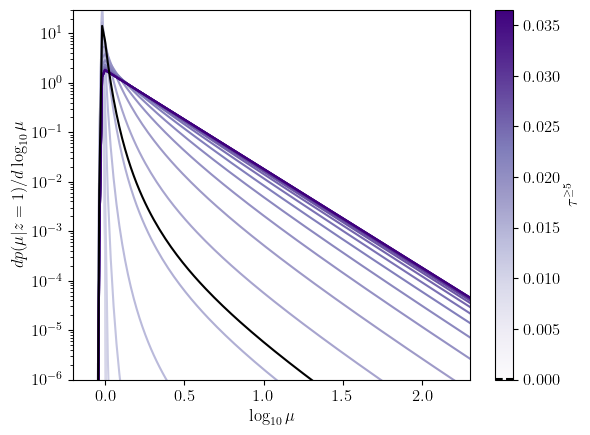

In [10]:
t0c_downsampled = t_const_space[::2]
n_lines = len(t0c_downsampled)
cmap = plt.colormaps['Purples']
norm = matplotlib.colors.Normalize(vmin=TAU_ARR.min(),vmax=TAU_ARR.max())

# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, n_lines))
f,ax = plt.subplots()
for i in range(n_lines):
    c= colors[i]
    t0c=t0c_downsampled[i]
    s = ax.plot(np.log10(TEST_MU),dists.logmag_pdf_Lambda(TEST_LNMU,sigma=0.01,t0=t0c,delta=-np.log(1.0465)), color=c)
ax.plot(np.log10(TEST_MU),dists.logmag_pdf(TEST_LNMU,z=1), color='k')

cbar = f.colorbar(plt.cm.ScalarMappable(cmap=cmap,norm=norm), ax=ax, label='$\\tau^{\geq 5}$')
cbar.ax.axhline(TAU_FID, c='k',ls='--')
plt.yscale("log")
plt.xlabel('$\log_{10}\mu$')
plt.ylabel('$dp(\mu|z=1)/d\log_{10} \mu$')
plt.ylim(bottom=1e-6,top=3e1)
plt.xlim(-0.2,np.log10(TEST_MU).max())
plt.savefig("../plots/p_mu_diff_taus.pdf")
plt.show()

# Figure 4
constraint on $\tau$ with non-detection of outliers in GWTC-3. The same as the analysis in `starting_over.ipynb` but without all the checks.

calculating Nexp


/Users/amandafarah/miniconda3/envs/lensing/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


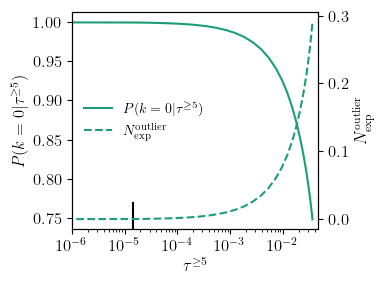

Largest allowed tau: 0.03649407232489162, smallest P: 0.7480395148493041


In [11]:
# if I didn't already do it
if not select:
    # get found injections for O3
    print("finding injections")
    obs_found_evs, identified_evs = af.find_injections(np_rng,INJECTIONS,m1max_thresh,Dmin_thresh,osnr,dist_unit,O3_MEASUREMENT_UNCERTAINTY,cosmo_dict=GWMOCKCAT_COSMO_DICT)

# calculate the expected number of outliers and detections as a function of t0c
print("calculating Nexp")
def nexp_for_parallel(i):
    return af.calc_Nexp(obs_found_evs, identified_evs, mu_interp, t_const=t_const_space[i], rate_evo_index=draw_distribution_params['lamb'])
placeholder = np.array(Parallel(n_jobs=-1)(delayed(nexp_for_parallel)(i) for i in range(len(t_const_space))))
Nexp_lensed_arr, Nexp_traditional_arr = np.nan_to_num(placeholder[:,0]), np.nan_to_num(placeholder[:,1])

# plot Nexp
fig, ax = plt.subplots(figsize=(4,3))# 2,1,sharex=True,sharey=False,figsize=(4,8),gridspec_kw={"hspace":0.05})
ax2 = ax.twinx()
line2 = ax2.plot(TAU_ARR,Nexp_lensed_arr,color=color_lensing_dark,ls='--',label="$N_{\\exp}^{\\mathrm{outlier}}$")[0]
ax2.set_ylabel("$N_{\\exp}^{\\mathrm{outlier}}$")

# plug Nexp into the poisson likelihood, but plot it as a function of tau
percentile=95
line1 = ax.plot(TAU_ARR,stats.poisson(Nexp_lensed_arr).pmf(0),color=color_lensing_dark,label='$P(k=0|\\tau^{\\geq 5})$')[0]
ax.axvline(TAU_FID,ymax=0.12,c='k')
# cdf = cumtrapz(x=Nexp_lensed_arr,y=stats.poisson(Nexp_lensed_arr).pmf(0), initial=0)
# percentile_idx = np.argmin(np.abs(cdf/cdf[-1]-percentile/100))
# plt.axvline(tau_arr[percentile_idx],ls='--',alpha=0.7,color=color_lensing_dark,label='95th percentile')
ax.set_ylabel('$P(k=0|\\tau^{\\geq 5})$')

lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax.legend(lines, labels, loc='center left',framealpha=0)
ax.set_xlabel('$\\tau^{\geq 5}$')
ax.set_xlim(1e-6,TAU_ARR.max()+0.01)
ax.set_xscale('log')
plt.tight_layout()
plt.savefig("../plots/P_tau_gwtc3.pdf",bbox_inches='tight')
plt.show()

# cdf = cumtrapz(x=Nexp_lensed_arr,y=stats.poisson(Nexp_lensed_arr).pmf(0), initial=0)
# plt.plot(TAU_ARR,stats.poisson(Nexp_lensed_arr).pmf(0)/cdf[-1],color=color_lensing_dark,label='posterior')
# percentile_idx = np.argmin(np.abs(cdf/cdf[-1]-percentile/100))
# plt.axvline(TAU_ARR[percentile_idx],ls='--',alpha=0.7,color=color_lensing_dark,label='95th percentile')
# plt.xlabel('$\\tau^{>5}$')
# plt.xlim(-0.0001,TAU_ARR.max()+0.0001)
# plt.ylabel('$p(\\tau^{>5}|N_{\\mathrm{outlier}}=0)$')
# plt.legend(loc='upper center',framealpha=0)
# plt.show()

# print(f"{percentile}th percentile of p(tau): {tau_arr[percentile_idx]}")

print(f"Largest allowed tau: {TAU_ARR[-1]}, smallest P: {stats.poisson(Nexp_lensed_arr[-1]).pmf(0)}")
with open("../output/lowest_P_tau_gwtc3.txt", 'w') as f:
    print(f"{stats.poisson(Nexp_lensed_arr[-1]).pmf(0):.3f}",file=f)

# Figure 5
$\tau$ constraints in different observing runs. 
- a) Zero outlier case for several detectors
- b) One-outlier case for seceral detectors

GWTC-3
For zero outliers, the 95th percentile of p(tau) is 0.03507936470832878
O4
22631074 found injections
703143 injections found and identified as outliers


/Users/amandafarah/miniconda3/envs/lensing/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


For zero outliers, the 95th percentile of p(tau) is 0.0338018347832038
O5
36790862 found injections
1471715 injections found and identified as outliers


/Users/amandafarah/miniconda3/envs/lensing/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


For zero outliers, the 95th percentile of p(tau) is 0.009602706526137298
Einstein Telescope
reducing # of injs
740716 found injections
31789 injections found and identified as outliers
For zero outliers, the 95th percentile of p(tau) is 0.0003814538120398574


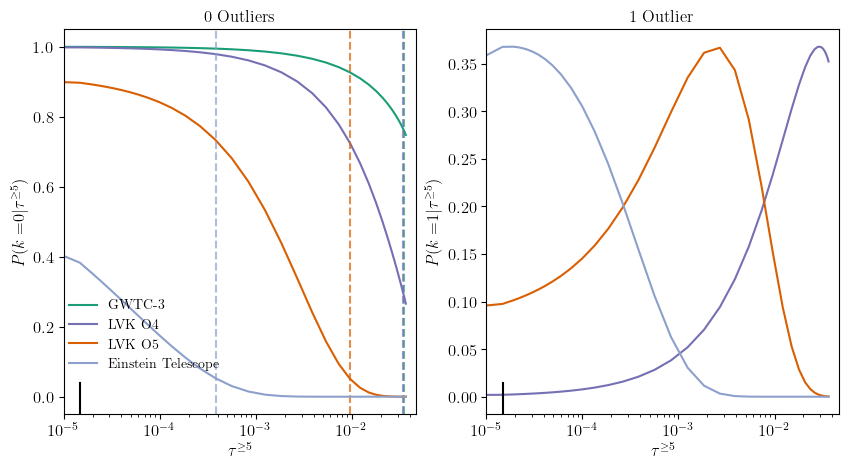

In [13]:
percentile=95
detectors = ['GWTC-3','O4','O5','Einstein Telescope']
selection_labels = ['aligo_O3actual_L1','aligo_O4low', 'aplus_design_O5', 'ET_design']
meas_uncert_dicts = [ # taken from Jose's paper 
    O3_MEASUREMENT_UNCERTAINTY,
    dict(threshold_snr=8.,snr=1.,mc=8e-2,Theta=8e-2,eta=1e-2),
    dict(threshold_snr=8.,snr=1.,mc=3e-2,Theta=5e-2,eta=5e-3),
    dict(threshold_snr=8.,snr=1.,mc=5e-3,Theta=2e-2,eta=7e-4),
]
# estimates for how many events we will observe in each run, for purposes of creating the outlier PPDs. Estimated without lensing
num_evs = [69, 69*3, 1000, 10000] #TODO: get more realistic #s for this, maybe just calc Nexp with our model and no lensing?

# calculate observing times
O4_total_obs_time = np.array([34,42,36])/52 # convert weeks to years, each enrty is a chunk of O4
# percent of time at least 1 LIGO detector was on. 
# This is the sum of the 3-IFO duty cycle, 2-IFO duty cycle, and half of the 1-IFO duty cycle 
# (the 1/2 is assuming that V, L, and H all have similar duty cycles, which is slightly wrong but it shouldn't be a big effect)
O4_duty_cycle = np.array([1-.166,.368+.311+.208/2,.346+.391+.173/2]) 
O4_OBS_TIME = np.sum(O4_total_obs_time * O4_duty_cycle)
O3_total_obs_time = np.array([26,21])/52
O3_duty_cycle = np.array([.445+.374+.150/2,.510+.343+.112/2])
O3_OBS_TIME = np.sum(O3_total_obs_time * O3_duty_cycle)
O5_total_obs_time = 3
O5_duty_cycle = np.max(O4_duty_cycle) # probably on the high end of O4's? Since we keep getting better?
O5_OBS_TIME = O5_duty_cycle*O5_total_obs_time
observing_time = [O3_OBS_TIME,O4_OBS_TIME,O5_OBS_TIME,1] # in years
colors = [color_lensing_dark, color_og_dark,color_alt_dark,color_og_light]
# save the magnifications for each detector to use in Fig 5.
detected_bools = dict()
identified_bools = dict()

# save the Nexp arrays just in case
Nexp_lensed = np.zeros((len(detectors),len(t_const_space)))
Nexp_traditional = np.zeros_like(Nexp_lensed)
m1_max, dlmin = np.zeros(len(detectors)), np.zeros(len(detectors))

f, ax = plt.subplots(1,2,figsize=(10,5),sharex=True,sharey=False)

for i in range(len(detectors)):
    print(detectors[i])
    lab = detectors[i]
    if lab[0]=="O":
        lab = "LVK "+lab
    if i>0:
        if detectors[i]=='Einstein Telescope':
            # downsample injs for ET since so many will be found that its computationally difficult to carry them around
            print("reducing # of injs")
            num_inj = int(1e6)
            injections_i = {key:INJECTIONS[key][:num_inj] for key in INJECTIONS.keys() if 'num' not in key}
            injections_i['num_injections'] = num_inj
        else:
            injections_i = INJECTIONS
            num_inj = int(1e7)
        osnr_i, dist_unit = interpolate_optimal_snr_grid(
                f"/Users/amandafarah/Library/Mobile Documents/com~apple~CloudDocs/projects/mock-PE/sensitivity/optimal_snr_{selection_labels[i]}.h5")
        
        samples_in_sigmas = (samples-samples.mean())/samples.std()
        new_sigma = samples.std() * np.sqrt(num_evs[0]/num_evs[i])
        rescaled_samples = samples.mean() + samples_in_sigmas*new_sigma
        rescaled_samples['gaussian_mass_maximum'] = samples['gaussian_mass_maximum']
        rescaled_samples['amax'] = samples['amax']

        m1_max[i], dlmin[i] = af.create_ppds(np_rng,
                                            rescaled_samples,
                                            optimal_snr_interpolator=osnr_i,
                                            distance_unit=dist_unit,
                                            uncert_dict=meas_uncert_dicts[i],
                                            cosmo_dict=GWMOCKCAT_COSMO_DICT,
                                            n_evs=num_evs[i],
                                            num_injs=num_inj # we don't have to use the same number for this and the lensed injs, but might as well
                                            )
        
        obs_found_evs, identified_evs = af.find_injections(np_rng,injections_i,m1_max[i],dlmin[i],osnr_i,dist_unit,meas_uncert_dicts[i],cosmo_dict=GWMOCKCAT_COSMO_DICT)
        detected_bools[detectors[i]], identified_bools[detectors[i]] = obs_found_evs['found_bool'], identified_evs['identified_bool']
        # calculate the expected number of outliers and detections as a function of t0c
        def nexp_for_parallel(i):
            return af.calc_Nexp(obs_found_evs, identified_evs, mu_interp, t_const=t_const_space[i], rate_evo_index=draw_distribution_params['lamb'])
        placeholder = np.array(Parallel(n_jobs=-1)(delayed(nexp_for_parallel)(j) for j in range(len(t_const_space))))
        Nexp_lensed[i], Nexp_traditional[i] = np.nan_to_num(placeholder[:,0])*observing_time[i], np.nan_to_num(placeholder[:,1])*observing_time[i]
    
        Nexp_lensed[i] += Nexp_lensed[i-1]
        Nexp_traditional[i] += Nexp_traditional[i-1]
    else:
        detected_bools[detectors[i]], identified_bools[detectors[i]] = obs_found_evs['found_bool'], identified_evs['identified_bool']
        Nexp_lensed[i] = Nexp_lensed_arr
        Nexp_traditional[i] = Nexp_traditional_arr

    # plug Nexp into the poisson likelihood, but plot it as a function of tau
    cdf = cumtrapz(x=Nexp_lensed[i],y=stats.poisson(Nexp_lensed[i]).pmf(0), initial=0)
    ax[0].plot(TAU_ARR,stats.poisson(Nexp_lensed[i]).pmf(0), color=colors[i], label=lab)
    percentile_idx = np.argmin(np.abs(cdf/cdf[-1]-percentile/100))
    ax[0].axvline(TAU_ARR[percentile_idx],ls='--',alpha=0.7,color=colors[i])
    print(f"For zero outliers, the {percentile}th percentile of p(tau) is {TAU_ARR[percentile_idx]}")
    with open(f"../output/95_perc_{detectors[i]}.txt", 'w') as f:
        print(f"{round(TAU_ARR[percentile_idx],3):.3f}",file=f)
    
    cdf = cumtrapz(x=Nexp_lensed[i],y=stats.poisson(Nexp_lensed[i]).pmf(1), initial=0)
    if i > 0:
        ax[1].plot(TAU_ARR,stats.poisson(Nexp_lensed[i]).pmf(1), color=colors[i], label=lab)
        with open(f"../output/CI_{detectors[i]}.txt", 'w') as f:
            idxs = [np.argmin(np.abs(cdf/cdf[-1]-q)) for q in [0.05,0.5,0.95]]
            median = TAU_ARR[idxs[1]]
            lower_err = median - TAU_ARR[idxs[0]]
            upper_err = TAU_ARR[idxs[2]] - median
            print(f"{median:.5f} + {upper_err:.5f} - {lower_err:.5f}",file=f)
    
    # ax[1].axvline(,ls='--',alpha=0.7,color=colors[i])
    # print(f"For one outlier, the {100-percentile}th percentile of p(tau) is {TAU_ARR[percentile_idx]}")

ax[0].legend(framealpha=0,loc=(2e-5,0.1))
for i in range(2):
    ax[i].set_xlabel('$\\tau^{\geq 5}$')
    ax[i].set_ylabel('$P(k=$'+f'{i}'+'$|\\tau^{\geq 5})$')
    ax[i].axvline(TAU_FID,ymax=0.08,c='k')
    ax[i].set_xlim(1e-5,TAU_ARR.max()+0.01)
    ax[i].set_xscale('log')
ax[0].set_title(f"0 Outliers")
ax[1].set_title(f"1 Outlier")
plt.savefig("../plots/P_tau_projections_twopanel.pdf")
plt.show()

## Time to observe an outlier
This plot didn't make it in the paper but we do use the numbers

for an O4 detector and t0c=0, we would expect 1 outlier after 870.8 years


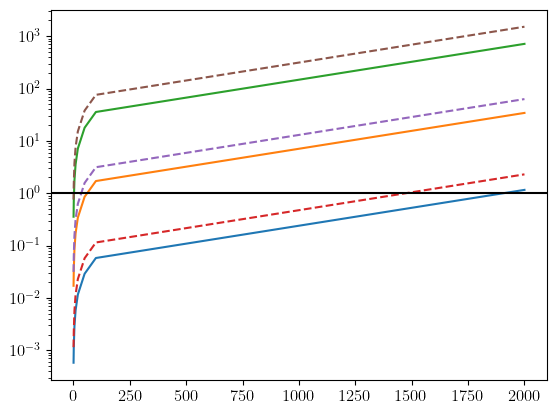

In [14]:
# how many years would we have to observe before seeing an outlier?

obs_times = [1,2,5,10,20,50,100,2000]
mid_tau = 1.24783801e-03
Nexp_o3_vals = [Nexp_lensed_arr[t_const_space==0],Nexp_lensed_arr[np.isclose(TAU_ARR,mid_tau)],Nexp_lensed_arr[t_const_space==100]]
Nexp_o4_vals = [Nexp_lensed[1][t_const_space==0],Nexp_lensed[1][np.isclose(TAU_ARR,mid_tau)],Nexp_lensed[1][t_const_space==100]]
for n in Nexp_o3_vals:
    plt.plot(obs_times,n/O3_OBS_TIME*obs_times)
for n in Nexp_o4_vals:
    plt.plot(obs_times,n/O4_OBS_TIME*obs_times, ls='--')
print(f"for an O4 detector and t0c=0, we would expect 1 outlier after {np.interp(1,Nexp_o4_vals[0]/O4_OBS_TIME*obs_times,obs_times):.1f} years",)
with open(f"../output/years_for_outlier_fid_O4.txt", 'w') as f:
    print(f"{O4_OBS_TIME/Nexp_o4_vals[0][0]:.0f}",file=f)
with open(f"../output/years_for_outlier_mid_O4.txt", 'w') as f:
    print(f"{O4_OBS_TIME/Nexp_o4_vals[1][0]:.0f}",file=f)

with open("../output/mid_tgf.tex", 'w') as f:
    str_list = f"{1.24289687e-03:.2E}".split("E")
    str_list[-1] = "{"+str_list[-1][0] + str_list[-1][-1] +"}"
    expr = "\\times 10^".join(str_list)
    print(f"${expr}$",file=f)

plt.axhline(1,c='k')
plt.yscale('log')
plt.show()


# Figure 6
$p(\mu|\det)$ vs $p(\mu)$ for various detectors. Show these are different.

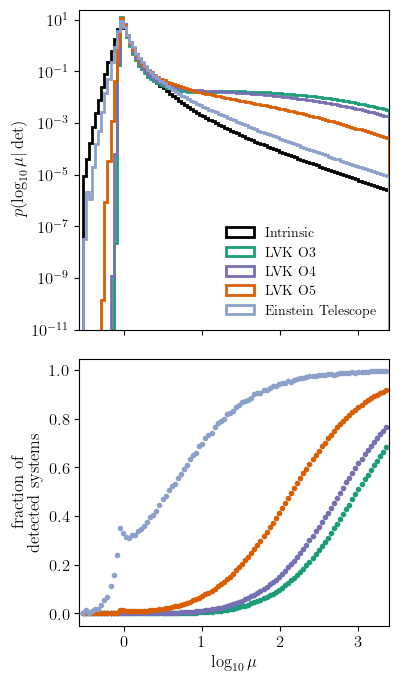

In [15]:
f, ax = plt.subplots(2,1,sharex=True,sharey=False,gridspec_kw={'hspace':0.1},height_ratios=(1.2,1),figsize=(4,8))
hist_kwargs = dict(histtype='step',bins=100,density=True,linewidth=2)
mags = INJECTIONS['magnification']
logmags = np.log10(mags)
weights=mu_interp((logmags,INJECTIONS['true_redshift'],0.0))/INJECTIONS['lnmu_pdraw']#/INJECTIONS['magnification']
ax[0].hist(logmags, weights=weights,color='k',label='Intrinsic',**hist_kwargs)
h_intrinsic, b_intrinsic = np.histogram(logmags,bins=hist_kwargs['bins'],weights=weights,density=False)
for i in range(len(detectors)):
    if i==0:
        lab="O3"
    else:
        lab=detectors[i]
    if lab[0]=="O":
        lab = "LVK "+lab
    if lab=="Einstein Telescope":
        logmags = np.log10(injections_i['magnification'])
        weights = mu_interp((logmags,injections_i['true_redshift'],0.0))/injections_i['lnmu_pdraw']
        h_intrinsic, b_intrinsic = np.histogram(logmags,bins=hist_kwargs['bins'],weights=weights,density=False)
    ax[0].hist(logmags[detected_bools[detectors[i]]], 
               weights=weights[detected_bools[detectors[i]]],
               color=colors[i],
               label=lab,
               **hist_kwargs)
    height, _ =  np.histogram(logmags[detected_bools[detectors[i]]],bins=b_intrinsic,weights=weights[detected_bools[detectors[i]]],density=False)
    ax[1].scatter(b_intrinsic[:-1],height/h_intrinsic,color=colors[i],marker='.')
ax[0].legend(ncol=1,framealpha=0)
ax[0].set_yscale('log')
ax[0].set_xlim(logmags.min()-0.05,logmags.max())
ax[0].set_ylabel('$p(\log_{10}{\mu}|\det)$')
ax[0].set_ylim(1e-11,25)

ax[1].set_xlabel('$\log_{10}{\mu}$')
ax[1].set_ylabel('fraction of\n detected systems')
plt.savefig("../plots/Pdet_of_mu.pdf")
plt.show()


In [16]:
weights = mu_interp((logmags,INJECTIONS['true_redshift'],0.0))
for d in detectors:
    found_bool = detected_bools[d]
    identified_bool = identified_bools[d]

    found_weights = weights[found_bool]
    identified_weights = found_weights[identified_bool]

    efficiency = np.sum(found_weights) / Ninj
    variance = np.sum(found_weights**2) / Ninj**2 - efficiency**2 / Ninj
    Neff_found = efficiency**2/variance 

    efficiency = np.sum(identified_weights) / Ninj
    variance = np.sum(identified_weights**2) / Ninj**2 - efficiency**2 / Ninj
    Neff_identified = efficiency**2/variance 

    print(d, round(Neff_found), round(Neff_identified))

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (1000000,) and arg 1 with shape (100000000,).